In [49]:
import numpy as np
import matplotlib.pyplot as plt
from RL import ModelBasedRL
from RL import GridWorldMDP
from RL import GridDisplay
import copy

In [247]:
grid_rows = 4
grid_cols = 4
num_actions = 4
terminal_states = []

mdp = GridWorldMDP(grid_rows, grid_cols, num_actions, terminal_states, reward_noise=.5, prob_noise=.0)

In [250]:
# Created instance of class to run model based algorithms.
model_rl = ModelBasedRL(max_iter=10)

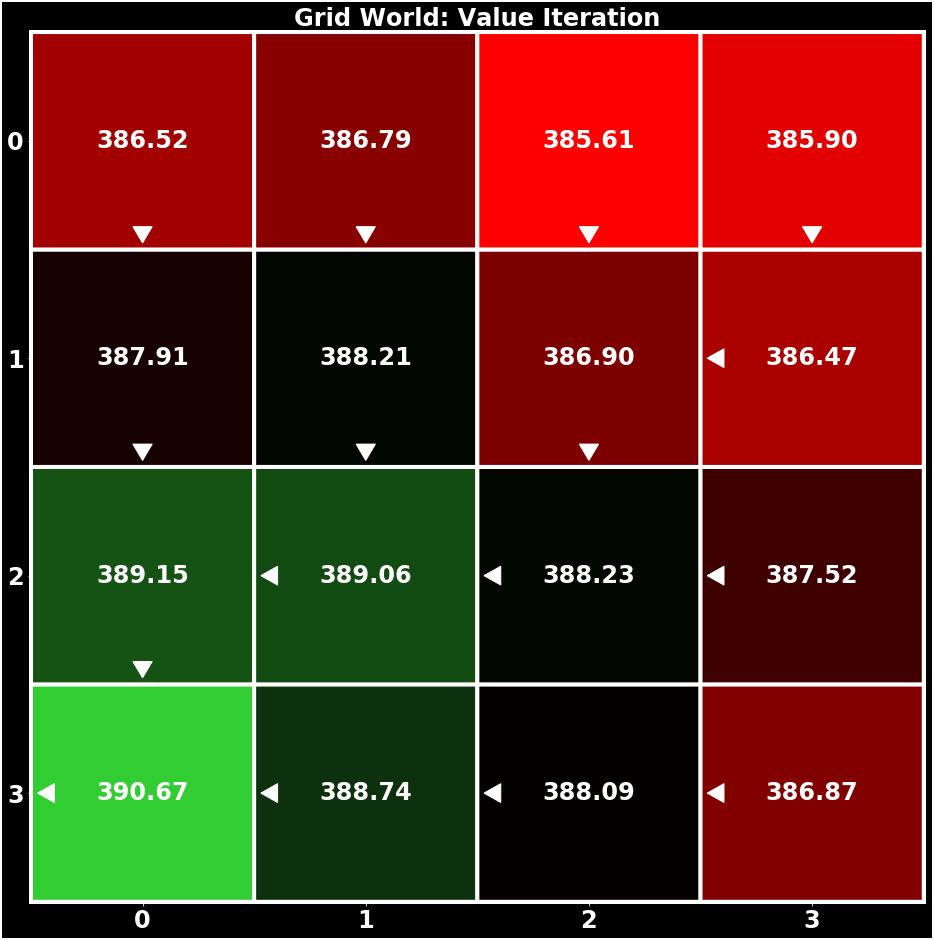

In [251]:
model_rl.value_iteration(mdp)

display = GridDisplay(model_rl, mdp)
display.show_values(title='Grid World: Value Iteration')

In [53]:
model_rl.test_optimal_v(mdp)
print 'Max v-error', model_rl.error.max()

Max v-error 0.0


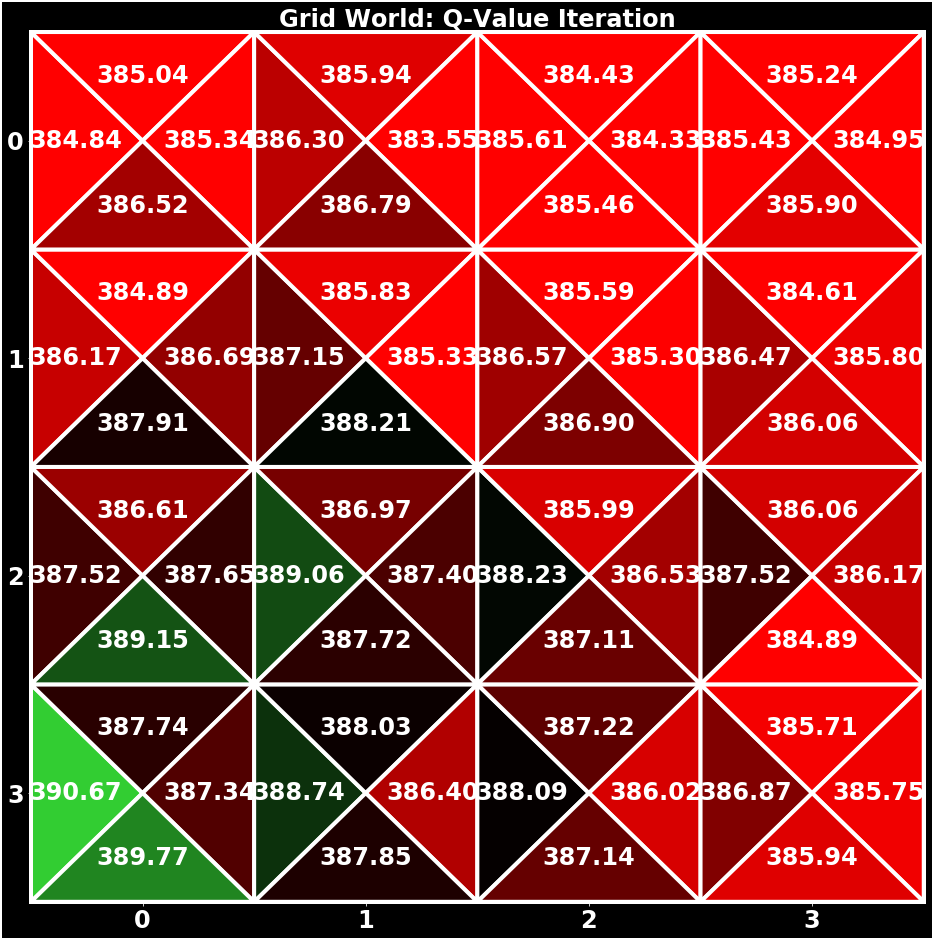

In [252]:
model_rl.q_value_iteration(mdp)

display = GridDisplay(model_rl, mdp)
display.show_q_values(title='Grid World: Q-Value Iteration')

In [55]:
model_rl.test_optimal_q(mdp)
print 'Max q-error', model_rl.error.max()

Max q-error 0.0


In [56]:
from cvxopt import matrix, solvers

In [218]:
def irl(n_states, n_actions, transition_probability, policy, discount, Rmax, l1):
    A = set(range(n_actions)) 
    
    def T(a, s):
        """
        Shorthand for a dot product used a lot in the LP formulation.
        """
        
        T_ = np.dot(transition_probability[policy[s], s] -
                      transition_probability[a, s],
                      np.linalg.inv(np.eye(n_states) -
                        discount*transition_probability[policy[s]]))
        return T_
            

    transition_probability = np.transpose(transition_probability, (1, 0, 2))

    c = -np.hstack([np.zeros(n_states), np.ones(n_states),
                    -l1*np.ones(n_states)])
    zero_stack1 = np.zeros((n_states*(n_actions-1), n_states))
    T_stack = np.vstack([
        -T(a, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
    I_stack1 = np.vstack([
        np.eye(1, n_states, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
    I_stack2 = np.eye(n_states)
    zero_stack2 = np.zeros((n_states, n_states))

    D_left = np.vstack([T_stack, T_stack, -I_stack2, I_stack2])
    D_middle = np.vstack([I_stack1, zero_stack1, zero_stack2, zero_stack2])
    D_right = np.vstack([zero_stack1, zero_stack1, -I_stack2, -I_stack2])

    D = np.hstack([D_left, D_middle, D_right])
    b = np.zeros((n_states*(n_actions-1)*2 + 2*n_states, 1))
    bounds = np.array([(None, None)]*2*n_states + [(-Rmax, Rmax)]*n_states)

    D_bounds = np.hstack([
        np.vstack([
            -np.eye(n_states),
            np.eye(n_states)]),
        np.vstack([
            np.zeros((n_states, n_states)),
            np.zeros((n_states, n_states))]),
        np.vstack([
            np.zeros((n_states, n_states)),
            np.zeros((n_states, n_states))])])
    b_bounds = np.vstack([Rmax*np.ones((n_states, 1))]*2)
    D = np.vstack((D, D_bounds))
    b = np.vstack((b, b_bounds))
    A_ub = matrix(D)
    b = matrix(b)
    c = matrix(c)
    solvers.options['show_progress'] = False
    results = solvers.lp(c, A_ub, b)
    r = np.asarray(results["x"][:n_states], dtype=np.double)

    r = r.reshape((n_states,))
    
    return r

In [232]:
n_states = mdp.n
n_actions = mdp.m
transition_probability = mdp.P
policy = model_rl.policy
discount = .99
Rmax = mdp.R.max()
l1 = 100000000

[3 0 1 3 2 0 1 0 1 1 1 3 0 0 2 1]
[3 0 1 3 2 0 1 0 1 1 1 3 0 0 2 1]


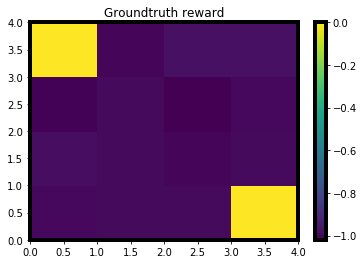

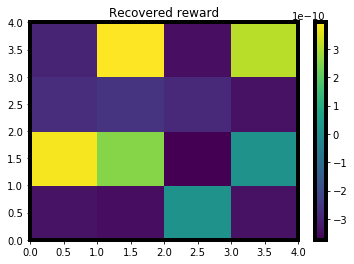

[[ 0.         -1.00766037 -0.9798025  -0.97974639]
 [-1.012566   -0.99508875 -1.01980237 -0.99888361]
 [-0.98568735 -0.99299284 -1.00399836 -0.99511619]
 [-0.99681832 -0.99338845 -0.99565212  0.        ]]
[[ -2.97029497e-10   3.93661956e-10  -3.46164630e-10   3.11267388e-10]
 [ -2.77284328e-10  -2.58158912e-10  -2.88503349e-10  -3.40064304e-10]
 [  3.84510352e-10   2.53428531e-10  -3.73751544e-10   1.68605158e-11]
 [ -3.36362411e-10  -3.49408695e-10   1.77547730e-11  -3.37992339e-10]]
[3 0 1 3 2 0 1 0 1 1 1 3 0 0 2 1]
[3 0 1 3 2 0 1 0 1 1 1 3 0 0 2 1]


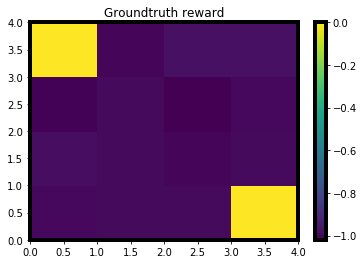

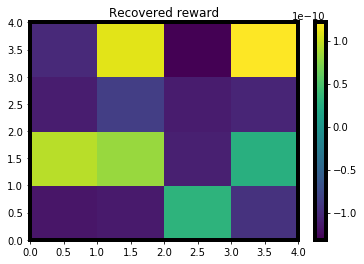

[[ 0.         -1.00766037 -0.9798025  -0.97974639]
 [-1.012566   -0.99508875 -1.01980237 -0.99888361]
 [-0.98568735 -0.99299284 -1.00399836 -0.99511619]
 [-0.99681832 -0.99338845 -0.99565212  0.        ]]
[[ -1.02272340e-10   1.09336358e-10  -1.31645651e-10   1.21106295e-10]
 [ -1.11544190e-10  -8.56307053e-11  -1.12840253e-10  -1.05643640e-10]
 [  9.42047537e-11   8.16192934e-11  -1.09259769e-10   2.81646614e-11]
 [ -1.17261652e-10  -1.14039626e-10   3.12874395e-11  -9.58780566e-11]]
[3 0 1 3 2 0 1 0 1 1 1 3 0 0 2 1]
[3 0 1 3 2 0 1 0 1 1 1 3 0 0 2 1]


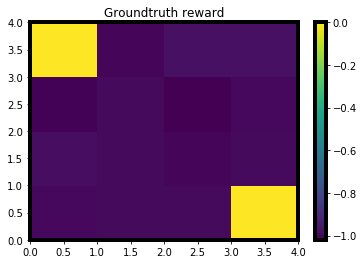

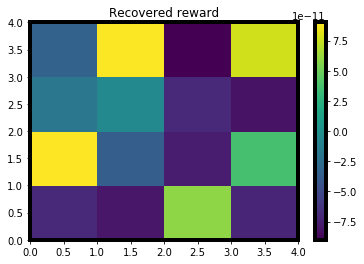

[[ 0.         -1.00766037 -0.9798025  -0.97974639]
 [-1.012566   -0.99508875 -1.01980237 -0.99888361]
 [-0.98568735 -0.99299284 -1.00399836 -0.99511619]
 [-0.99681832 -0.99338845 -0.99565212  0.        ]]
[[ -3.37409880e-11   8.88168348e-11  -9.01164978e-11   7.68781775e-11]
 [ -1.89827091e-11  -5.61238734e-12  -6.94247516e-11  -8.14706549e-11]
 [  9.01190986e-11  -3.66585633e-11  -7.67055240e-11   3.70910271e-11]
 [ -6.95675785e-11  -7.93139032e-11   5.96299937e-11  -7.16109300e-11]]
[3 0 1 3 2 0 1 0 1 1 1 3 0 0 2 1]
[3 0 1 3 2 0 1 0 1 1 1 3 0 0 2 1]


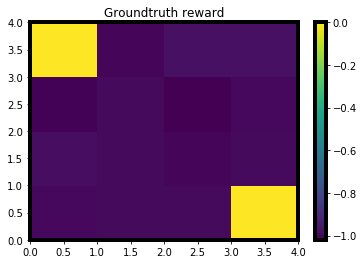

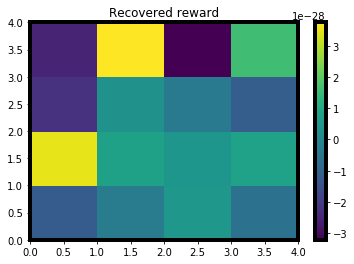

[[ 0.         -1.00766037 -0.9798025  -0.97974639]
 [-1.012566   -0.99508875 -1.01980237 -0.99888361]
 [-0.98568735 -0.99299284 -1.00399836 -0.99511619]
 [-0.99681832 -0.99338845 -0.99565212  0.        ]]
[[ -2.51978619e-28   3.74661628e-28  -3.20976925e-28   1.60731455e-28]
 [ -2.20943110e-28   2.93990342e-29  -3.81405568e-29  -1.15840952e-28]
 [  3.48358906e-28   7.75053611e-29   4.36723831e-29   8.09162294e-29]
 [ -1.20798066e-28  -3.49082872e-29   5.09283515e-29  -6.25418698e-29]]


In [245]:
for discount in np.arange(.09, 1, .1):
    for l1 in [10**power for power in xrange(-10, 10)]:
        r = irl(n_states=n_states, n_actions=n_actions, transition_probability=transition_probability, policy=policy, discount=discount, Rmax=Rmax, l1=l1)

        irl_mdp = copy.deepcopy(mdp)

        for i in xrange(irl_mdp.n):
            irl_mdp.R[:, :, i] = r[i] 

        model_rl.q_value_iteration(irl_mdp)

        if np.array_equal(model_rl.policy - policy, np.zeros(mdp.n)):

            print model_rl.policy
            print policy

            ground_r = np.zeros(mdp.n)
            for i in xrange(mdp.n):
                ground_r[i] = mdp.R[i,:,:].mean()

            plt.pcolor(np.flipud(ground_r.reshape((grid_rows, grid_cols))))
            plt.colorbar()
            plt.title("Groundtruth reward")
            plt.show()

            plt.pcolor(np.flipud(r.reshape((grid_rows, grid_cols))))
            plt.colorbar()
            plt.title("Recovered reward")
            plt.show()

            print ground_r.reshape((grid_rows, grid_cols))
            print r.reshape((grid_rows, grid_cols))

In [234]:
mdp.idx_to_action_names

{0: 'N', 1: 'W', 2: 'S', 3: 'E'}